# Marker and source-marker reprogramming of Most Permissive Boolean networks and ensembles with BoNesis

Loïc Paulevé
> <sup></sup> Univ. Bordeaux, CNRS, Bordeaux INP, LaBRI, UMR 5800, F-33400 Talence, France

#### Abstract
> Boolean networks (BNs) are discrete dynamical systems with applications to the modeling of cellular behaviors. In this paper, we demonstrate how the software BoNesis can be employed to exhaustively identify combinations of perturbations which enforce properties on their fixed points and attractors. We consider marker properties, which specify that some components are fixed to a specific value.
> We study 4 variants of the marker reprogramming problem: the reprogramming of fixed points, of minimal trap spaces, and of fixed points and minimal trap spaces reachable from a given initial configuration with the most permissive update mode. The perturbations consist of fixing a set of components to a fixed value. They can destroy and create new attractors.
> In each case, we give an upper bound on their theoretical computational complexity, and give an implementation of the resolution using the BoNesis Python framework.
> Finally, we lift the reprogramming problems to ensembles of BNs, as supported by *BoNesis*, bringing insight on possible and universal reprogramming strategies.
> This paper can be executed and modified interactively.

**Keywords**: Discrete dynamical systems, Control, Minimal trap spaces, Attractors, Reachability

# Introduction

Boolean networks (BNs) are formal discrete dynamical systems with pertinent applications for modeling cellular differentiation and fate decision processes <cite data-citep="Saez-Rodriguez2009,Cohen2015,Schwab2021,Zanudo21,Montagud22">(<a href="https://doi.org/10.1038/msb.2009.87">Saez-Rodriguez et al., 2009</a>; <a href="https://doi.org/10.1371/journal.pcbi.1004571">Cohen et al., 2015</a>; <a href="https://doi.org/10.1016/j.csbj.2021.09.012">Schwab et al., 2021</a>; <a href="https://doi.org/10.1158/0008-5472.can-21-1208">Zañudo et al., 2021</a>; <a href="https://doi.org/10.7554/elife.72626">Montagud et al., 2022</a>)</cite>. In these applications, BNs aim at capturing the stable behaviors (attractors) and the transient dynamics (trajectories) of the cell. From this perspective, BNs offer a formal framework for predicting perturbations that destabilize the system and drive it towards a desired new stable behavior. BN *control* or BN *reprogramming*, in reference to cellular reprogramming which aims at converting cell types, is thus receiving a lot of interest from the computational systems biology community <cite data-citep="Zanudo2015,Yang2018,Biane2018,Mandon2019,Cifuentes2020,Su2020,Rozum2021">(<a href="https://doi.org/10.1371/journal.pcbi.1004193">Zañudo et al., 2015</a>; <a href="https://doi.org/10.3389/fphys.2018.00454">Yang et al., 2018</a>; <a href="https://doi.org/10.1109/tcbb.2018.2889102">Biane et al., 2018</a>; <a href="https://doi.org/10.1007/978-3-030-31304-3_1">Mandon et al., 2019</a>; <a href="https://doi.org/10.1007/978-3-030-60327-4_9">Cifuentes Fontanals et al., 2020</a>; <a href="https://doi.org/10.1093/bioinformatics/btaa752">Su and Pang, 2020</a>; <a href="https://doi.org/10.1093/bioinformatics/btab825">Rozum et al., 2021</a>)</cite>.

The reprogramming of BNs led to a range of methods and tools addressing different instantiations of this problem: with different type of perturbations (instantaneous, temporary, permanent), different temporal modalities (one-step, sequential), different scopes (global reprogramming or from a given initial condition), different restrictions on the target attractor (fixed points only, attractors of the original "wild-type" BN). On top of that, the *update mode* of the BN, which determines how the trajectories are computed, can play an important role on the predictions.

In this paper, we address the BN reprogramming with the Most Permissive (MP) update mode, where attractors are the minimal trap spaces of the BN <cite data-citep="Pauleve2020">(<a href="https://doi.org/10.1038/s41467-020-18112-5">Paulevé et al., 2020</a>)</cite>. The problems we tackle are related to *marker* reprogramming: the desired target attractors are specified by a set of markers, associating a subset of nodes of the network to fixed values (e.g., $A=1,C=0$). After reprogramming, all the configurations in all (reachable) attractors must be compatible with these markers. Importantly, the target attractors are not necessarily attractors of the original (wild-type) BN: the reprogramming can destroy and create new attractors. In particular, if there is no attractor in the original model matching with the marker, the reprogramming will identify perturbations that will create such an attractor and ensure its reachability. This is a substantial difference with many of the methods in the literature. Moreover, the approach we present here can return *all* the possible solutions, possibly up to a given maximum number of perturbations to apply, and possibly avoiding *uncontrollable* nodes.

We address the following BN reprogramming problems in the scope of the MP update mode:

* *P1*: Marker reprogramming of fixed points: after reprogramming, all the fixed points of the BN match with the given markers; optionally, we can also ensure that at least one fixed point exists.
* *P2*: Source-marker reprogramming of fixed points: after reprogramming, all the fixed points that are *reachable from the given initial configuration* match with the given markers.
* *P3*: Marker reprogramming of attractors: after reprogramming, all the configurations of all the MP attractors (the minimal trap spaces) of the BN match with the given markers.
* *P4*: Source-marker reprogramming of attractors: after reprogramming, all the configurations of all the attractors that are *reachable from the given initial configuration* match with the given markers.

MP fixed points match with the fixed points of the global Boolean map of the BN and are thus identical to the fixed points of the (a)synchronous update modes. MP attractors match with so-called *minimal trap spaces* of the BN, which are the smallest sub-hypercubes closed by the Boolean map. Problem *P1* has been already addressed in the literature, notably by <cite data-citet="Biane2018"><a href="https://doi.org/10.1109/TCBB.2018.2889102">Biane et al. (2018)</a></cite> with the *ActoNet* method and by <cite data-citet="Moon22"><a href="https://doi.org/10.1016/j.ejor.2021.10.019">Moon et al. (2022a)</a></cite>, based on bilevel integer programming. To our knowledge, none of the other problems have been addressed completely in the literature.

The software *BoNesis* ([github.com/bnediction/bonesis](https://github.com/bnediction/bonesis)) provides a generic environment for the automated construction of BNs with MP update mode from specified structural and dynamical properties. The properties are translated into a logic satisfiability problem, expressed in Answer-Set Programming (ASP). Initially, *BoNesis* has been designed for performing BN synthesis <cite data-citep="bn-synthesis-ICTAI19">(<a href="https://doi.org/10.1109/ICTAI.2019.00014">Chevalier et al., 2019</a>)</cite>: solutions of the logic model correspond to BNs that possess the specified structural and dynamical properties. Leveraging this generic declarative specification of properties, *BoNesis* is a versatile tool for reasoning on BNs in general, with the MP update mode: besides synthesis, it can be used to do model checking, identify fixed points and attractors in ensemble of BNs, and identifying reprogramming strategies.

In this paper, we show how the software *BoNesis* can be employed to solve P1, P2, P3, and P4 in the scope of *locally-monotone* BNs, where each local function is *[unate](https://en.wikipedia.org/wiki/Unate_function)*, i.e., where each local function never depends on both positively and negatively from a same component. Locally-monotone BNs cover all the models where it assumed that a node cannot be both an activator and inhibitor of a same other node, which is a common assumption when modeling biological system.

*BoNesis* enables reasoning on *ensembles* of BNs: one of its basic input is the domain of BNs to consider. This domain could be reduced to a singleton BN: in that case, the reasoning is similar to standard model checking and reprogramming. In general, the domain is specified from an influence graph, possibly with additional constraints on the underlying logical functions. For BN synthesis, this domain is used to delimit symbolically the set of candidate models: *BoNesis* will output the subset of them that verify the desired dynamical properties. We show how problems P1 to P4 can be partly lifted to ensembles of BNs using this approach.

The paper is structured as follows. The *Methods* section gives the necessary background on BNs and MP update mode and formulation of elementary dynamical properties as satisfaction problems, as well as main principles of the *BoNesis* environment. The *Results* section  details how the different reprogramming problems P1-P4 can be addressed using *BoNesis* and shows some experiments to assess their scalability. Finally, the *Discussion* section sketches possible extensions of the addressed problems and underlines current challenges for their resolution.

This paper is *executable*: it contains snippets of Python code employing *BoNesis* to demonstrate its usage on small examples, including command line usage. Instructions for its execution are given at the beginning of the *Results* section.
It can be visualized online at [nbviewer.org/github/bnediction/reprogramming-with-bonesis/blob/release/paper.ipynb](https://nbviewer.org/github/bnediction/reprogramming-with-bonesis/blob/release/paper.ipynb) and interactively executed either online at [mybinder.org/v2/gh/bnediction/reprogramming-with-bonesis/release](https://mybinder.org/v2/gh/bnediction/reprogramming-with-bonesis/release) using [mybinder](https://mybinder.org/) online free service, or locally, following instructions given later in this paper.

# Methods

## Boolean networks and the Most Permissive update mode

### Basic definitions
A Boolean network (BN) of dimension $n$ is specified by a function $f: \mathbb B^n\to\mathbb B^n$ where $\mathbb B = \{0,1\}$ is the Boolean domain. For $i\in \{1,\cdots,n\}$, $f_i:\mathbb B^n\to\mathbb B$ is referred to as the *local function* of the *component* $i$.
The Boolean vectors $x\in\mathbb B^n$ are called *configurations*, where for any $i\in\{1,\cdots,n\}$, $x_i$ denotes the *state* of component $i$ in the configuration $x$.

A BN $f$ is *locally monotone* whenever every of its local functions are *unate*: for each $i\in\{1,\cdots,n\}$, there exists an ordering of components $\preceq^i\in \{\leq, \geq\}^n$ such that $\forall x,y\in \mathbb B^n$, $(x_1\preceq^i_1 y_1 \wedge \cdots x_n\preceq^i_n y_n) \implies f_i(x) \leq f_i(y)$. Intuitively, a BN is locally monotone whenever each of its local function can be expressed in propositional logic such that each variable appears either never or always with the same sign. For instance $f_1(x) = x_1\vee (\neg x_3 \wedge x_2)$ is unate, whereas $f_1(x) = x_2 \oplus x_3 = (x_2\wedge\neg x_3)\vee (\neg x_2\wedge x_3)$ is not unate.

*Example.* The BN $f$ of dimension $3$ with $f_1(x)=\neg x_2$, $f_2(x)=\neg x_1$, and $f_3(x) = \neg x_1\wedge x_2$ is locally monotone; and an instance of application is $f(000)=110$.

Locally monotone BNs should not be confused with *monotone* BNs where a component appears in *all* local functions with the same sign. Monotone BNs are a particular case of locally-monotone BNs.

### Update modes

Given a BN $f$ and a configuration $x$, the *update mode* specifies how to compute the next configuration. There is a vast zoo of update modes <cite data-citep="PS22">(<a href="https://hal.archives-ouvertes.fr/hal-03736899">Paulevé and Sené, 2022</a>)</cite>, but traditionally, two modes are usually considered in biological modeling: the *synchronous* (or parallel) deterministic mode, where the next configuration is given by its application to $f$ ($x$ is succeeded by $f(x)$), and the *fully asynchronous* (often denoted only asynchronous) where the next configuration results from the application of only one local function, chosen non-deterministically.

However, (a)synchronous update modes do not lead to a complete qualitative abstraction of quantitative systems and preclude the prediction of trajectories that are actually feasible when considering time scales or concentration scales. The *Most Permissive* (MP) <cite data-citep="Pauleve2020,Pauleve2021">(<a href="https://doi.org/10.1038/s41467-020-18112-5">Paulevé et al., 2020</a>; <a href="https://doi.org/10.4230/OASIcs.AUTOMATA.2021.10">Paulevé and Sené, 2021</a>)</cite> is a recently-introduced update mode which brings the formal guarantee to capture any trajectory that is feasible by any quantitative system compatible with the Boolean network (see <a href="https://doi.org/10.1038/s41467-020-18112-5">(Paulevé et al., 2020)</a> for details).
The main idea behind the MP update mode is to systematically consider a potential delay when a component changes state, and consider any additional transitions that could occur if the changing component is in an intermediate state. It can be modeled as additional *dynamic* states "increase" ($\nearrow$) and "decrease" ($\searrow$): when a component can be activated, it will first go through the "increase" state where it can be interpreted as either 0 or 1 by the other components, until eventually reaching the Boolean 1 state; and symmetrically for deactivation.
A formal definition of MP dynamics is given later in this section.

### Perturbations

In this paper we will consider BN *perturbations* that modify the local functions of some components so they become a constant function. Perturbations model mutations, where a gene is silenced or constitutively activated. Mathematically, a perturbation is a map associating a set of components to a Boolean value, for instance, $P = \{ 2 \mapsto 0, 4 \mapsto 1\}$. Given a perturbation $P$, the *perturbed BN* $f/P$ is given by, for each component $i\in \{1,\ldots,n\}$:
$$
(f/P)_i(x) = \begin{cases}
b & \text{ if }i \mapsto b \in P\\
f_i(x) & \text{otherwise.}
\end{cases}
$$

## Quantified Boolean expressions and computational complexity

A Boolean expression is a logic formula composed of Boolean variables and propositional logic operators (negation $\neg$, conjunction $\wedge$, disjunction $\vee$, implication $\implies$, equivalence $\equiv$, exclusive disjunction $\oplus$).
Given variables $x_1,\cdots,x_m$, a *quantified* Boolean expression is of the form $Q_1 x_1 \cdots Q_n x_m \phi(x_1, \cdots, x_m)$ where $Q_1, \cdots, Q_m$ can be the existential $\exists$ or universal $\forall$ quantifier, and $\phi(x_1,\cdots,x_m)$ a quantifier-free Boolean expression composed of variables $x_1, \cdots, x_m$.
For instance, consider the quantified Boolean expression "$\exists x_1\exists x_2 \forall x_3\, (x_3 \wedge x_1) \vee (\neg x_3 \wedge \neg x_2)$". This expression is satisfiable: fix $x_1=1$ and $x_2=0$, then the Boolean expression becomes equivalent to $x_3 \vee \neg x_3$ which is true for all assignments of $x_3$.

Deciding whether such an expression is true (satisfiable) is a fundamental problem in computer science. The complexity of this problem actually depends on the alternation of quantifiers. Thus, in the following we will classify the quantified Boolean expressions by their sequence of quantifiers $Q_1\cdots Q_m$ but ignoring repetitions: an $\exists\exists\forall\forall\forall\exists\exists\forall$-expression has the same decision complexity as an $\exists\forall\exists\forall$-expression.

Computational complexity <cite data-citep="Papadimitriou">(<a href="https://pdfcoffee.com/computational-complexity-christos-papadimitrioupdf-pdf-free.html">Papadimitriou, 1993</a>)</cite> is a fundamental theory of computer science to classify decision problems: a (decision) problem is in class C whenever there exists an algorithm of worst-case complexity C, C referring to either a time or space complexity. For instance, the class PTIME gathers all the problems that can be decided in time polynomial with the size of the input (e.g., the length of the Boolean expression).

The decision of satisfiability of $\exists$-expressions is the infamous (Boolean) SAT(isfiability) problem, which is NP-complete: it can be solved by a non-deterministic polynomial time algorithm, and it is among the hardest problems in this class: any problem in NP can be (efficiently) transformed into a SAT problem. In practice, our computers being deterministic, the resolution of the SAT problems employs algorithms running in worst-case  time and space exponential with the number of variables in the Boolean expression. However, modern SAT solvers can approach expressions with thousands to millions of variables.

The decision of satisfiability of $\forall$-expressions can be seen as a complementary problem to $\exists$-expression: $\forall X~\phi(X)$ is satisfiable if and only if $\exists X~\neg\phi(X)$ is not satisfiable: it is a *co*NP-complete problem. It is not known whether coNP = NP.

Then, the alternation of quantifiers makes the problem climbing into the so-called polynomial hierarchy[^1]. $\exists\ldots$-expressions are $\Sigma_k^{\mathrm P}$-complete problems, where $k$ is the number of alternating quantifiers (starting with $\exists$), while $\forall\ldots$-expressions are $\Pi_k^{\mathrm P}$-complete
($\Sigma_1^{\mathrm P}$=NP and $\Pi_1^{\mathrm P}$=coNP). It is not known yet whether all these complexity classes are equal, but in practice, algorithms of resolution scale rapidly down with their height in the polynomial hierarchy. Each of these complexity classes are included in PSPACE, the class of problems solvable in polynomial space. PSPACE-complete problems, such as the verification of properties of asynchronous BNs, are known to be difficult to tackle in practice (currently limited to a couple of hundreds of variables in the case of BNs).

The reader should keep in mind that the length of the expression is a crucial parameter for the decision complexity. When variables have a finite domain, one can rewrite quantified Boolean expression in a universal-free one. However, the length of the obtained expression will be exponentially larger.

In the rest of the paper, for the sake of simplicity, we will not fully detail the size of the quantified Boolean expression we derive, and are expected to be of length linear or polynomial with the size of the BN.

[^1]: See [en.wikipedia.org/wiki/Polynomial_hierarchy](https://en.wikipedia.org/wiki/Polynomial_hierarchy)

## Elementary dynamical properties and their complexity

We present the formal aspects of the MP dynamics that are employed in the rest of the paper, i.e., related to attractors and the reachability of attractors. The proofs and full MP definition and properties can be found in <cite data-citep="Pauleve2020">(<a href="https://doi.org/10.1038/s41467-020-18112-5">Paulevé et al., 2020</a>)</cite>.

### Sub-hypercubes and trap spaces

A sub-hypercube specifies for each dimension of the BN if it is either fixed to a Boolean value, or free: it can be characterized by a vector $h\in \{0,1,*\}^n$. Its *vertices* are denoted by $c(h) = \{ x\in \mathbb B^n\mid h_i\neq *\implies x_i=h_i\}$. For instance, $h=0**$ is a sub-hypercube of dimension 3, with $c(h) = \{000, 001, 010, 011\}$.

A sub-hypercube $h$ is a *trap space* whenever for each of its vertices $x\in c(h)$, $f(x)$ is also one of its vertices ($h$ is closed by $f$). In particular, the (sub-)hypercube $\mathbf *_n$ is always a trap space.

A sub-hypercube $h$ is *smaller* than a sub-hypercube $h'$, denoted by $h \preceq h'$ whenever $c(h)\subseteq c(h')$. Equivalently, this means that each non-free component of $h'$ is fixed to the same value in $h$: $h \preceq h' \iff \forall i\in \{1,\ldots,n\}, h'_i\neq *\implies h_i=h'_i$.


### MP attractors are minimal trap spaces

The attractors of MP dynamics are the *minimal trap spaces* of the Boolean function $f$ <cite data-citep="Pauleve2020">(<a href="https://doi.org/10.1038/s41467-020-18112-5">Paulevé et al., 2020</a>)</cite>, i.e., the trap spaces which do not include strictly smaller trap spaces.
Thus, we denote MP attractors by sub-hypercubes, i.e., an MP attractor $A$ is a vector in $\{0,1,*\}^n$.
Therefore, a component with a $*$ value in an MP attractor $A$ indicates that the component that can always oscillate between 0 and 1 in the (cyclic) attractor.

The computational complexity of decision problems related to minimal trap spaces has been extensively addressed in <cite data-citep="TrapSpaceComplexity">(<a href="https://doi.org/10.48550/arXiv.2212.12756">Moon et al., 2022b</a>)</cite> with different representations of Boolean networks.
For the case of local functions represented with propositional logic, as we consider here, deciding whether a sub-hypercube is a trap space is coNP-complete problem, whereas deciding whether it is a *minimal* trap space is a coNP<sup>coNP</sup>-complete problem, i.e., equivalent to the decision of satisfiability of $\forall\exists$ expressions.
In the case of *locally-monotone* BNs, deciding whether a sub-hypercube is a trap space is in PTIME, whereas deciding whether it is a minimal trap spaces is a coNP-complete problem, i.e., equivalent to the decision of satisfiability of $\forall$-expressions.


### MP reachability of attractors

Given a configuration $x$ and an MP attractor $A\in \{0,1,*\}^n$, there is an MP trajectory from $x$ to any configuration $y\in A$ if and only if $A$ is smaller than the smallest trap space *containing* $x$. We write $\operatorname{reach}(x,y)$ the existence of such a trajectory.

Let us denote by $\operatorname{TS}(x) \in \{0,1,*\}^n$ the smallest trap space containing $x$. The computation of $h=\operatorname{TS}(x)$ can be performed  from $x$ by iteratively freeing the components necessarily to fulfill the closeness property. Here is a sketch of algorithm, where `SAT(h, f[i] = -x[i])` is true if and only if there exists a configuration $y\in c(h)$ such that $f_i(y)=\neg x_i$:
```
Algorithm TS(x: configuration)
Returns sub-hypercube h
--
h := x
repeat
   changed := false
   for i in 1..n:
      if h[i] != * and SAT(h, f[i] = -x[i]):
          h[i] := *
          changed := true
while changed
```
In the worst case, this algorithm makes a quadratic number of calls to the `SAT` problem.
Therefore, the decision of MP reachability of attractors is in PTIME<sup>NP</sup> in general[^2], and PTIME in the locally-monotone case.

Note that the general MP reachability property is not addressed here, but its overall complexity is identical. With (a)synchronous update modes, it is a PSPACE-complete problem.

[^2]: this problem is actually in NP when allowing a number of variables quadratic with $n$

### Belonging to an MP attractor

In the following, we will consider the problem of deciding whether a given configuration $x$ belongs to an MP attractor of $f$. We write $\operatorname{IN-ATTRACTOR}(x)$ such a property. This can be verified in two steps: (1) compute the smallest trap spaces containing $x$, noted $\operatorname{TS}(x)$, and (2) verify whether $\operatorname{TS}(x)$ is a minimal trap space. This later property is true if and only if for any vertex $y$ of $\operatorname{TS}(x)$, the minimal trap space containing $y$ is equal to $\operatorname{TS}(x)$:
$$
\operatorname{IN-ATTRACTOR}(x) \equiv \forall y \in c(\operatorname{TS}(x)), \operatorname{TS}(y) = \operatorname{TS}(x) \enspace.
$$

Finally, given a set of perturbations $P$, we write $\operatorname{TS}_P(x)$ for the small trap space of perturbed BN $(f/P)$ containing $x$, and $\operatorname{IN-ATTRACTOR}_P(x)$ the property of $x$ belonging to an attractor of the perturbed BN $(f/P)$.

## BoNesis

*BoNesis* ([github.com/bnediction/bonesis](https://github.com/bnediction/bonesis)) is a Python library which has been primarily designed for identifying BNs satisfying user-given dynamical properties among a given domain of BNs and with the MP update mode.
It takes as input (1) a domain of BNs $\mathbb F$, and (2) a set of Boolean dynamical properties $\phi$, and can enumerate the BNs $f \in \mathbb F$ such that $f\models \phi$, i.e., $f$ verifies the properties $\phi$.

Currently, the domain of BNs $\mathbb F$ can be one of the following:

- A singleton locally-monotone BN $\mathbb F=\{f\}$. In that case, *BoNesis* can be employed as a model checker to verify that $f$ has the specified dynamical properties. In this paper, this is the main setting we will consider, in order to predict perturbations to reprogram the attractors of $f$.
- An explicit ensemble of locally-monotone BNs $\mathbb F=\{ f^1,\cdots, f^m \}$.
- Any locally-monotone BN matching with a given *influence graph* $\mathcal G$: $\mathbb F = \{ f\mid G(f)\subseteq \mathcal G\}$. An influence graph is a signed digraph between components, i.e., of the form $(\{1,\cdots,n\},V)$ with $V\subseteq \{1,\cdots,n\}\times \{+1,-1\}\times \{1,\cdots n\}$. The influence graph of a BN $f$, denoted by $G(f)$ has an edge $i\xrightarrow{s} j$ if and only there exists a configuration $x\in\mathbb B^n$ such that $f_j(x_1, \ldots, x_{i-1}, 1, x_{i+1},\ldots, x_n) - f_j(x_1, \ldots, x_{i-1}, 0, x_{i+1},\ldots, x_n) = s$.
- Any locally-monotone BN matching with a partially-defined BN following the AEON framework <cite data-citep="Benes2021">(<a href="https://doi.org/10.1007/978-3-030-85633-5_14">Beneš et al., 2021</a>)</cite>.

*BoNesis* offers a Python programming interface to declare the dynamical properties over BNs, including reachability, fixed points and trap spaces. *BoNesis* relies on Answer-Set Programming (ASP) and the ASP solver [*clingo*](https://potassco.org/clingo) for the enumeration of solutions. ASP is a declarative logic programming framework for expressing combinatorial decision problems and enumerate their solutions, possibly with optimizations. ASP can be employed for efficiently solving $\exists$- and $\exists\forall$-expressions, thus having an expressiveness higher than classical SAT.

We emphasize that *BoNesis* is currently restricted to locally-monotone BNs only for which efficient logical encoding of domains of models are possible. Whereas it is a common assumption when modeling of biological systems (a node cannot be both an activator and inhibitor of a same other node), non-monotone BNs are also employed, and cannot be addressed with the current implementation.

The usage of *BoNesis* Python programming interface and command line will be explained along with the code snippets provided in the next sections.

# Results

We show how the general declarative approach of *BoNesis* can be instantiated to compute the complete solutions to the P1, P2, P3, and P4 reprogramming problems on BNs, and also extend the reasoning to ensembles of BNs.
Importantly, note that *BoNesis* currently supports only locally-monotone BNs.

This is an *executable paper* which demonstrates the use of *BoNesis* for the reprogramming of BNs. The corresponding notebook can be downloaded from [nbviewer.org/github/bnediction/reprogramming-with-bonesis/blob/release/paper.ipynb](https://nbviewer.org/github/bnediction/reprogramming-with-bonesis/blob/release/paper.ipynb). Its execution requires the [Jupyter notebook](https://jupyter.org/) system, [Python](https://python.org), and the Python package `bonesis` to be installed, see [github.com/bnediction/bonesis](https://github.com/bnediction/bonesis) for instructions.
Alternatively, the notebook can be executed within the CoLoMoTo Docker distribution <cite data-citep="ColomotoDocker">(<a href="http://dx.doi.org/10.3389/fphys.2018.00680">Naldi et al., 2018</a>)</cite>, using the Docker image `colomoto/colomoto-docker:2023-02-01`, which can be launched as follows:
```
pip install colomoto-docker
colomoto-docker -V 2023-02-01
```
then open [http://127.0.0.1:8888](http://127.0.0.1:8888) and upload the notebook from the Jupyter interface.
See [github.com/bnediction/reprogramming-with-bonesis](https://github.com/bnediction/reprogramming-with-bonesis) for further help.

In [1]:
#!pip install --user bonesis  # uncomment to install bonesis
import bonesis

In [2]:
from colomoto_jupyter import tabulate # for display
import pandas as pd # for display
import mpbn # for analyzing individual Boolean networks with MP update mode
from colomoto.minibn import BooleanNetwork

Alternatively, the computation of reprogramming perturbations from single Boolean networks can be performed using the command line program`bonesis-reprogramming`, provided alongside the `bonesis` Python package. We detail its usage in each case.

## Marker reprogramming of Boolean networks

We first consider the reprogramming of a single BN $f$ of dimension $n$. In the framework of *BoNesis*, this means the domain of BNs is the singleton $\mathbb F = \{ f \}$.

A marker $M$ is a map associating a subset of components of $f$ to a Boolean value. For instance, $M = \{ 1\mapsto 0, 3\mapsto 1\}$ is the marker where component $1$ is $0$ and component $3$ is $1$. We denote by $dom(M)$ the domain of the map $M$, i.e., in our example $dom(M) = \{ 1, 3\}$.
Given a configuration $x\in \mathbb B^n$, we say $x$ matches with a marker $M$, denoted by $x\models M$, if and only if $\forall i\in dom(M), x_i=M(i)$.
Given a set of configurations $A\subseteq \mathbb B^n$, we say $A$ matches with a marker $M$ if and only if each of its configurations match with $M$ ($\forall x\in A, x\models M$).
Given $k\in\mathbb N$, we denote by $\mathbb M^{\leq k}$ the sets of maps associating at most $k$ components among $\{1, \cdots, n\}$ to a Boolean value. 

The objective of marker-reprogramming is to identify perturbations so that all the fixed points/attractors of the perturbed $f$ match with the marker $M$. The source-marker reprogramming then focuses on the fixed points/attractors reachable from a given initial configuration only, thus potentially requiring fewer perturbations.


A very important aspect of marker reprogramming is that it accounts for the creation and deletion of attractors due to the perturbation. Thus, in general, the attractors of the reprogrammed BN are different from the attractors of the input (wild-type) BN.

In this section, we tackle the following instantiations of the reprogramming problem:

1. Marker reprogramming of fixed points (*P1*);
2. Source-marker reprogramming of fixed points (*P2*);
3. Marker reprogramming of attractors (*P3*);
4. Source-marker reprogramming of attractors (*P4*).

In each case, we briefly study the complexity of the associated decision problem (existence of a perturbation given the desired reprogramming property), and give the Python and command line recipe to identify the perturbations with *BoNesis*.
The following table summarizes the results, with the complexity in the locally-monotone case and command line usage:

| Problem | Complexity | Command line |
|:---:|:---|:---|
| P1 | $\exists\forall$ | `[base] --fixpoints`
| P2 | $\exists\forall$ | `[base] --fixpoints --reachable-from z`
| P3 | $\exists\forall\exists$ | `[base]`
| P4 | $\exists\forall\exists$ | `[base] --reachable-from z`

where `[base]` is the command line `bonesis-reprogramming model.bnet M k`, with `model.bnet` the path to a file in  [BooleanNet format](http://colomoto.org/biolqm/doc/format-bnet.html), `M` specifies the marker as a JSON map, `k` is the maximum number of simultaneous perturbations, and `z` is the initial configuration as a JSON map.
For instance,
```bash
bonesis-reprogramming model.bnet '{"A": 0, "C": 1}' 3 \
        --reachable-from '{"A":1, "B":0, "C":0,"D":0}'
```

### Marker-reprogramming of fixed points (P1)

We identify the perturbations $P$ of at most $k$ components so that all the fixed points of $f/P$ match with the given marker $M$. The associated decision problem can be expressed as the  following $\exists\forall$-expression, hence being at most in $\Sigma_2^{\mathrm P}$:

\begin{equation}
\exists P\in \mathbb M^{\leq k}, \forall x\in\mathbb B^n, (f/P)(x) = x \Rightarrow x\models M
\end{equation}

"There exists a perturbation being a map of at most $k$ components to a Boolean value, such that for all configurations $x\in\mathbb B^n$, if $x$ is a fixed point of the perturbed BN $(f/P)$, then $x$ matches with the marker $M$".

Remark that any BN having no fixed point verify the above equation with an empty perturbation. Thus, in practice, one may also expect that the perturbed BN possesses at least one fixed point:

\begin{equation}
\exists P\in \mathbb M^{\leq k}, \exists y\in\mathbb B^n, (f/P)(y) = y, \forall x\in\mathbb B^n, (f/P)(x) = x \Rightarrow x\models M\enspace.
\end{equation}

With the *BoNesis* Python interface, this reprogramming property can be declared as follows, where `f` is a BN, `M` the marker (specified as Python dictionary associating a subset of components to a Boolean value), and `k` the maximum number of components that can be perturbed (at most $n$):

In [3]:
def marker_reprogramming_fixpoints(f: BooleanNetwork, 
                                   M: dict[str,bool],
                                   k: int, ensure_exists:bool=True):
    # f: Boolean network; M: marker; k: maximum number of components to perturb
    bo = bonesis.BoNesis(f)
    P = bo.Some(max_size=k) # perturbations to identify
    with bo.mutant(P):
        # impose that all the fixed points of the perturbed BN match with M
        bo.all_fixpoints(bo.obs(M))
        if ensure_exists:
            # impose the existence of at least one fixed point matching with M
            bo.fixed(~bo.obs(M)) 
    return P.assignments()

The line `bo = bonesis.BoNesis(f)` instantiates a *BoNesis* object `bo` with the domain `f`. In this section, we assume that `f` is a single Boolean network. It can be either the path to a BooleanNet file, a `minibn` object, for instance as returned by the `biolqm.to_minibn` function for importing models from various formats, or a Python dictionary, associating components to a Boolean function. Examples are given below.
Then, the line `P = bo.Some(max_size=k)` declares a variable that will consist of a map associating at most `k` components to a Boolean value (the perturbation to be identified).
The instruction `with bo.mutant(P)` opens a context where dynamical properties will be verified against the BN `f` with the perturbation `P` applied.
Within this mutant context, we declare with `bo.all_fixpoints(bo.obs(M))` that each fixed point of the perturbed model matches with `M`. Moreover, whenever `ensure_exists` is true, the constraint `bo.fixed(~bo.obs(M))` imposes that the configuration associated with `M` (`~bo.obs(M)`) is a fixed point.
Finally, `P.assignments()` returns an iterator over all the possible assignments of `P` that fulfill the above dynamical properties.

The corresponding command line is of the form
```bash
bonesis-reprogramming model.bnet M k --fixpoints
```
where `model.bnet` is a BN encoded in BooleanNet format, `M` specifies the marker as a JSON map, and `k` is the maximum number of perturbations.
The existence of at least one fixed point can be lifted with the option `--allow-no-fixpoint`.

*Example.* We illustrate the marker-reprogramming of fixed points on a small toy BN example, which has no fixed point. In the following, we use `colomoto.minibn.BooleanNetwork` to define this BN.

In [4]:
f = BooleanNetwork({
    "A": "B",
    "B": "!A",
    "C": "!A & B"
})
f

A <- B
B <- !A
C <- !A&B

This example BN has two components in negative feedback: they will oscillate forever. The state of the third component `C` is then determined by the state of the oscillating components. The following command returns its influence graph:

# computing graph layout...


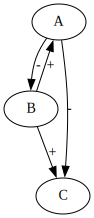

In [5]:
f.influence_graph()

With the (fully) asynchronous update mode, the system has a single attractor, consisting of all the configurations of the network.

# computing graph layout...


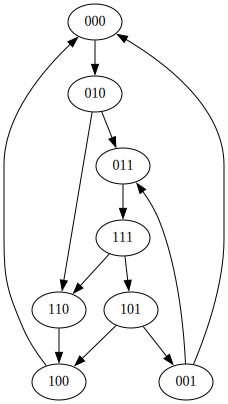

In [6]:
f.dynamics("asynchronous")

Recall that the fixed points are identical in asynchronous and MP. We use [`mpbn`](https://github.com/bnediction/mpbn) to analyze the dynamical properties with the MP update mode:

In [7]:
mf = mpbn.MPBooleanNetwork(f)
list(mf.fixedpoints())

[]

In [8]:
list(mf.attractors())

[{'A': '*', 'B': '*', 'C': '*'}]

Indeed, the network has no fixed points, and its attractor is the full hypercube of dimension 3.

Using the `marker_reprogramming_fixpoints` snippet defined above, we identify all perturbations of at most 2 components which ensure that (1) all the fixed points have `C` active, and (2) at least one fixed point exists:

In [9]:
list(marker_reprogramming_fixpoints(f, {"C": 1}, 2))

Grounding...done in 0.0s


[{'A': 0}, {'C': 1, 'B': 0}, {'A': 1, 'C': 1}, {'B': 1, 'C': 1}]

Indeed, fixing `A` to 0 breaks the negative feedback, and make `B` converge to 1. There, `C` converges to state 1.
Then, remark that fixing `C` to 1 is not enough to fulfill the property, as `A` and `B` still oscillate. Thus, one of these 2 must be fixed as well, to any value. The solution `{'A': 0, 'C': 1}` is not returned as `{'A': 0}` is sufficient to acquire the desired dynamical property.

In our *BoNesis* code snippet defined above, by default we ensure that the perturbed BN possesses at least one fixed point. When relaxing this constraint, we obtain that the empty perturbation is the (unique) minimal solution, as `f` has no fixed point.

In [10]:
list(marker_reprogramming_fixpoints(f, {"C": 1}, 2, ensure_exists=False))

Grounding...done in 0.0s


[{}]

In the following, we demonstrate how to perform the same computation with the command line. By default, the reprogramming of fixed points adds the constraint that at least one fixed point must exist.

In [11]:
with open("example1.bnet", "w") as fp:
    fp.write(f.source())
%cat example1.bnet

A, B
B, !A
C, !A&B


In [12]:
!bonesis-reprogramming example1.bnet '{"C": 1}' 2 --fixpoints

{'A': 0}
{'C': 1, 'B': 0}
{'A': 1, 'C': 1}
{'B': 1, 'C': 1}


Adding the option `--allow-no-fixpoint` would return an empty perturbation as unique minimal solution.

### Source-marker reprogramming of fixed points (P2)

Given an initial configuration $z$, we identify the perturbations $P$ of at most $k$ components so that all the fixed points of $f/P$ that are reachable from $z$ in $f/P$ match with the given marker $M$.
The associated decision problem can be expressed as the following $\exists\forall$-expression, hence being at most in $\Sigma_2^{\mathrm P}$:

\begin{equation}
\exists P\in\mathbb M^k, \forall x\in\mathbb B^n, ((f/P)(x)=x \wedge \operatorname{reach}_P(z,x))\implies x\models M
\end{equation}

"There exists a perturbation $P$ such that for any configuration $x\in\mathbb B^n$,
if $x$ is a fixed point of the perturbed BN $(f/P)$, and $x$ is reachable from $z$ in $(f/P)$, then $x$ must match with $M$".

As explained in the Method section, the reachability property boils down to computing the smallest trap space containing $z$: if it contains the fixed point $x$, then $x$ is reachable from $z$ with the MP update mode.

\begin{equation}
\exists P\in\mathbb M^k, \forall x\in\mathbb B^n, ((f/P)(x)=x \wedge 
x\in\operatorname{TS}_P(z))\implies x\models M\enspace.
\end{equation}

As with the previous case, in practice we may also want that there exists at least one fixed point reachable from $z$.

With the *BoNesis* Python interface, this reprogramming property is declared as follows, where `f` is a BN, `z` the initial configuration (Python dictionary), `M` the marker, and `k` the maximum number of components that can be perturbed (at most $n$):

In [13]:
def source_marker_reprogramming_fixpoints(f: BooleanNetwork,
                                          z: dict[str,bool],
                                          M: dict[str,bool],
                                          k: int):
    # f: Boolean network; z: initial configuration;
    # M: marker; k: maximum number of components to perturb
    bo = bonesis.BoNesis(f)
    P = bo.Some(max_size=k)  # perturbation to identify
    with bo.mutant(P):
        # all the fixed points reachable from z match with M
        ~bo.obs(z) >> "fixpoints" ^ {bo.obs(M)}
        # at least one fixed point matching with M is reachable from z
        ~bo.obs(z) >= bo.fixed(~bo.obs(M))
    return P.assignments()

Compared to the previous code snippet, this function relies on specific operators to restrict the properties to the fixed point reachable from `z`.
The instruction `~bo.obs(z)` refers to a specific configuration matching with `z`;
`~bo.obs(z) >> "fixpoints" ^ {bo.obs(M)}` specifies that all the fixed points reachable from such configuration have to match with at least one configuration given in the set `{bo.obs(M)}`, i.e., `M` in this case.
This property is satisfied whenever no fixed point are reachable. Thus, the next line ensures that at least one fixed point is reachable from the configuration associated with `z`: `bo.fixed(~bo.obs(M))` refers to one configuration which is a fixed point (in the perturbed BN), and which matches with `M`. Then, the binary operator `>=` declares the existence of a trajectory from its left to its right configuration.

Notice that with this formulation, in the case whenever `z` is only partially defined (some components are not associated to a Boolean value), a perturbation is returned as long as there exists at least one fully-defined configuration matching with $z$ which fulfil the specified dynamical properties.

The corresponding command line is of the form
```bash
bonesis-reprogramming model.bnet M k --fixpoints --reachable-from z
```
where `model.bnet` is a BN encoded in BooleanNet format, `M` specifies the marker as a JSON map, `k` is the maximum number of perturbations, and `z` is the initial configuration as a JSON map.
The existence of at least one fixed point can be lifted with the option `--allow-no-fixpoint`.

*Example.* Let us consider the following toy BN with two positive feedback cycles:

# computing graph layout...


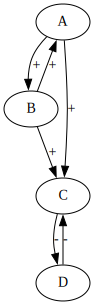

In [14]:
f = BooleanNetwork({
    "A": "B",
    "B": "A",
    "C": "!D & (A|B)",
    "D": "!C"
})
f.influence_graph()

This BN has 3 fixed points, 2 of which are reachable from the configuration where `A` and `B` are active, and `C` and `D` inactive:

# computing graph layout...


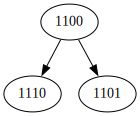

In [15]:
z = {"A": 1, "B": 1, "C": 0, "D": 0}
f.dynamics("asynchronous", init=z)

In [16]:
list(mpbn.MPBooleanNetwork(f).fixedpoints())

[{'A': 0, 'B': 0, 'C': 0, 'D': 1},
 {'A': 1, 'B': 1, 'C': 0, 'D': 1},
 {'A': 1, 'B': 1, 'C': 1, 'D': 0}]

In [17]:
list(mpbn.MPBooleanNetwork(f).fixedpoints(reachable_from=z))

[{'A': 1, 'B': 1, 'C': 1, 'D': 0}, {'A': 1, 'B': 1, 'C': 0, 'D': 1}]

Let us compare the results of the global marker-reprogramming of fixed points (P1) with the source-marker reprogramming of fixed points (P2), the objective being to have fixed points having `C` active.
In the first case, putting aside the perturbation of `C`, this necessitates to act on either `A` or `B` to prevent the existence of the fixed points where `A`, `B` and `C` are inactive:

In [18]:
list(marker_reprogramming_fixpoints(f, {"C": 1}, 2))

Grounding...done in 0.0s


[{'A': 1, 'D': 0}, {'B': 1, 'D': 0}, {'C': 1}]

Considering only the fixed points reachable from the configuration `z`, there is no need to act on `A` or `B`:

In [19]:
list(source_marker_reprogramming_fixpoints(f, z, {"C": 1}, 2))

Grounding...done in 0.0s


[{'D': 0}, {'C': 1}]

The command line program `bonesis-reprogramming` can perform P2 by specifying the `--rechable-from` option giving the initial configuration in JSON format:

In [20]:
with open("example2.bnet", "w") as fp:
    fp.write(f.source())

In [21]:
!bonesis-reprogramming example2.bnet '{"C": 1}' 2 --fixpoints \
    --reachable-from '{"A": 1, "B": 1, "C": 0, "D": 0}'

{'D': 0}
{'C': 1}


### Marker reprogramming of attractors (P3)

We identify the perturbations $P$ of at most $k$ components so that the configurations of the all the attractors of $f/P$ match with the given marker $M$ (i.e., in each attractor, the specified markers cannot oscillate).
The associated decision problem can be expressed as follows:

\begin{equation}
\exists P\in\mathbb M^k, \forall x\in\mathbb B^n, \operatorname{IN-ATTRACTOR}_P(x) \implies x\models M
\end{equation}

("There exists a perturbation $P$ of at most $k$ components, such that for all configurations $x$, if $x$ belongs to an attractor of the perturbed BN $f/P$, then $x$ matches with the specified markers $M$")

By restricting the range of the universal part of the equation to the configurations which do not match with the marker $M$, we obtain:
\begin{equation}
\exists P\in\mathbb M^k, \forall x\in\mathbb B^n: x\not\models M, \neg\operatorname{IN-ATTRACTOR}_P(x)
\end{equation}

The $\operatorname{IN-ATTRACTOR}$ property being itself a quantified Boolean expression, we obtain the following $\exists\forall\exists$-expression:

\begin{equation}
\exists P\in\mathbb M^k, \forall x\in\mathbb B^n: x\not\models M, \exists y\in\mathbb B^n,
   y\in \operatorname{TS}_P(x), \operatorname{TS}_P(y) \neq \operatorname{TS}_P(x)
\end{equation}

The problem of satisfiability of this quantified Boolean expression is beyond the expressiveness power of ASP which is limited to $\exists\forall$-expressions.
Nevertheless, we can approach this problem by its complementary: the existence of perturbations of size $k$ such that at least one configuration belonging to an attractor does *not* match with the marker $M$.
This complementary problem can be expressed with this following expression
\begin{equation}
\exists P\in\mathbb M^k, \exists x\in\mathbb B^n,x\not\models M \wedge \operatorname{IN-ATTRACTOR}_P(x)
\end{equation}
which is an $\exists\forall$-expression:
\begin{equation}
\exists P\in\mathbb M^k, \exists x\in\mathbb B^n, x\not\models M\wedge \forall y\in\mathbb B^n, y\in \operatorname{TS}_P(x) \implies \operatorname{TS}_P(y) \neq \operatorname{TS}_P(x)
\enspace.
\end{equation}

Because the domain of candidate perturbations $\mathbb M^{\leq k}$ is finite, one can first resolve the complementary problem, giving all bad perturbations, and returns its complement.

Notice that this approach is highly combinatorics, and is likely limited to identifying perturbations of small size. However, to our knowledge, this is the first implemented method which addresses the complement reprogramming of MP attractors, i.e., of the minimal trap spaces of the BN.

With the *BoNesis* Python interface, this reprogramming property is declared as follows, where `f` is a BN, `M` the marker, and `k` the maximum number of components that can be perturbed (at most $n$):

In [22]:
def marker_reprogramming(f: BooleanNetwork,
                         M: dict[str,bool],
                         k: int):
    bo = bonesis.BoNesis(f)
    coP = bo.Some(max_size=k)
    with bo.mutant(coP):
        x = bo.cfg()
        bo.in_attractor(x)
        x != bo.obs(M)
    return coP.complementary_assignments()

The idea of the above code snippet is to declare the property of being a bad perturbation (`coP`). In the context of this perturbation, we declare with `x=bo.cfg()` a configuration. Then, `bo.in_attractor(x)` imposes that `x` belongs to an attractor (minimal trap space) of the perturbed BN; and the `x != bo.obs(M)` instruction adds the constraint that `x` must not match with `M`.

The `.complementary_assignments()` method performs the computation of the complement of solutions. It solves the above problem with perturbation sizes ranging from 0 to `k`, and returns complement minimal perturbations only.

The corresponding command line is of the form
```bash
bonesis-reprogramming model.bnet M k
```
where `model.bnet` is a BN encoded in BooleanNet format, `M` specifies the marker as a JSON map, `k` is the maximum number of perturbations.

*Example.* Let us consider the following BN:

# computing graph layout...


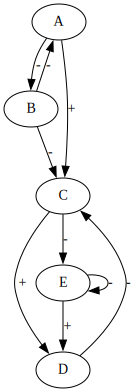

In [23]:
f = mpbn.MPBooleanNetwork({
    "A": "!B",
    "B": "!A",
    "C": "A & !B & !D",
    "D": "C | E",
    "E": "!C & !E",
})
f.influence_graph()

Essentially, `A` and `B` always stabilize to opposite states. Whenever `A` is active (and `B` inactive) then `C` will oscillate, otherwise it stabilizes to 0. In each case `D` and `E` oscillate.
This lead to the following MP attractors:

In [24]:
tabulate(list(f.attractors()))

,A,B,C,D,E
0,0,1,0,*,*
1,1,0,*,*,*


Let us say that our objective is to reprogram the BN such that all the attractors of the component `C` fixed to 1.
The reprogramming of fixed points (P1) gives the following solutions:

In [25]:
list(marker_reprogramming_fixpoints(f, {"C": 1}, 3))

Grounding...done in 0.0s


[{'D': 0}, {'C': 1}]

Putting aside the trivial solution of perturbing `C`, let us analyze the BN perturbed with the `D` forced to 0:

In [26]:
pf = f.copy()
pf["D"] = 0
tabulate(pf.attractors())

,A,B,C,D,E
1,0,1,0,0,*
0,1,0,1,0,0


The (only) fixed point of the network indeed has `C` active. However, it possesses another (cyclic) attractor, where `C` is inactive.
This example points out that focusing on fixed point reprogramming may lead to predicting perturbations which are not sufficient to ensure that all the attractors show the desired marker.

The complete attractor reprogramming returns that the perturbation of `D` must be coupled with a perturbation of `A` or `B`, in this case to destroy the cyclic attractor.

In [27]:
list(marker_reprogramming(f, {"C": 1}, 3))

Grounding...done in 0.0s
Grounding...done in 0.0s
Grounding...done in 0.0s
Grounding...done in 0.0s


[{'C': 1}, {'D': 0, 'B': 0}, {'D': 0, 'A': 1}]

The same results can be obtained using the command line as follows.

In [28]:
with open("example3.bnet", "w") as fp:
    fp.write(f.source())

In [29]:
!bonesis-reprogramming example3.bnet '{"C": 1}' 3

{'C': 1}
{'D': 0, 'B': 0}
{'D': 0, 'A': 1}


In other cases, the reprogramming of attractors may also lead to fewer required perturbations than focusing on fixed points, provided we enforce the existence of at least one fixed point. This can be illustrated with the following example:

# computing graph layout...


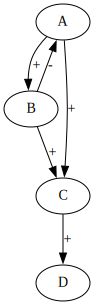

In [30]:
g = mpbn.MPBooleanNetwork({
    "A": "!B",
    "B": "A",
    "C": "A & B",
    "D": "C"
})
g.influence_graph()

Unperturbed, this network has a single cyclic attractor, as `A` and `B` are in a sustained oscillation.

In [31]:
tabulate(g.attractors())

,A,B,C,D
0,*,*,*,*


Enforcing that all attractors have `D` fixed to 1 can be achieved either by perturbing `A`, or by perturbing only `C`, letting `A` and `B` oscillate.

In [32]:
list(marker_reprogramming(g, {"D": 1}, 2))

Grounding...done in 0.0s
Grounding...done in 0.0s
Grounding...done in 0.0s


[{'A': 1}, {'C': 1}, {'D': 1}]

However, besides the forced activation of `A`, ensuring that all and at least one fixed point have `D` active always requires perturbing at least two components.

In [33]:
list(marker_reprogramming_fixpoints(g, {"D": 1}, 2))

Grounding...done in 0.0s


[{'A': 1},
 {'D': 1, 'A': 0},
 {'D': 1, 'B': 0},
 {'B': 1, 'D': 1},
 {'C': 1, 'A': 0},
 {'C': 1, 'B': 0},
 {'B': 1, 'C': 1}]

### Soure-marker reprograming of attractors (P4)

Given an initial configuration $z$, we identify the perturbations $P$ of at most $k$ components so that the configurations of the all the attractors of $f/P$ that are reachable from $z$  match with the given marker $M$ (i.e., in each reachable attractor, the specified markers cannot oscillate).
Thus, P4 is the same problem as P3, except that we focus only on attractors reachable from $z$, therefore potentially requiring fewer perturbations.

The associated decision problem can be expressed as follows:

\begin{equation}
\exists P\in\mathbb M^k, \forall x\in\mathbb B^n, x\models M \vee x\notin\bar\rho^{f/P}_{\mathrm{mp}}(z)  \vee \neg\operatorname{IN-ATTRACTOR}_P(x)
\end{equation}

("There exists a perturbation $P$ of at most $k$ components, such that for all configurations $x$, either $x$ matches with the marker $M$, or $x$ does not belong to an attractor, or $x$ is not reachable from $z$").

By integrating the definition of the $\operatorname{IN-ATTRACTOR}$ property, we obtain the following $\exists\forall\exists$-expression:
\begin{equation}
\exists P\in\mathbb M^k, \forall x\in\mathbb B^n, x\models M \vee x\notin\bar\rho^{f/P}_{\mathrm{mp}}(z) \vee \exists y\in\mathbb B^n,
   y\in \operatorname{TS}_P(x), \operatorname{TS}_P(y) \neq \operatorname{TS}_P(x)
\end{equation}

The resolution of the problem can be approached in a very similar way to P3, i.e., by solving its complement. The equation is almost the same, with the addition that $x$ must be reachable from $z$, leading to the $\exists\forall$-expression:
\begin{equation}
\exists P\in\mathbb M^k, \exists x\in\mathbb B^n, x\in\operatorname{TS}_P(z) \wedge x\not\models M\wedge \forall y\in\mathbb B^n, y\in \operatorname{TS}_P(x) \implies \operatorname{TS}_P(y) \neq \operatorname{TS}_P(x)
\enspace.
\end{equation}

With the *BoNesis* Python interface, this reprogramming property is declared as follows, where `f` is a BN, `z` the initial configuration, `M` the marker, and `k` the maximum number of components that can be perturbed (at most $n$):

In [34]:
def source_marker_reprogramming(f: BooleanNetwork,
                                z: dict[str,bool],
                                M: dict[str,bool],
                                k: int):
    bo = bonesis.BoNesis(f)
    coP = bo.Some(max_size=k)
    with bo.mutant(coP):
        x = bo.cfg()
        bo.in_attractor(x)
        x != bo.obs(M)
        ~bo.obs(z) >= x
    return coP.complementary_assignments()

The above code snippet is very similar to the previous `marker_reprogramming`, with the addition of the `~bo.obs(z) >= x` instruction which declares that `x`, a configuration which belongs to an attractor of the perturbed BN and which does not match with `M`, is reachable from `z`.

The corresponding command line is of the form
```bash
bonesis-reprogramming model.bnet M k --reachable-from z
```
where `model.bnet` is a BN encoded in BooleanNet format, `M` specifies the marker as a JSON map, `k` is the maximum number of perturbations, and `z` is the initial configuration as a JSON map.

*Example.* Let us consider again the BN `f` analyzed in the previous section. By focusing only on attractors reachable from the configuration where `A` is fixed to 1 and other nodes to 0, the reprogramming required to make all attractors have `C` fixed to 1 consists only of fixing `D` to 0. Note that in the specific example, the reprogramming of reachable fixed point would give an equivalent result.

In [35]:
z = f.zero()
z["A"] = 1
list(source_marker_reprogramming(f, z, {"C": 1}, 3))

Grounding...done in 0.0s
Grounding...done in 0.0s
Grounding...done in 0.0s
Grounding...done in 0.0s


[{'D': 0}, {'C': 1}]

The same results can be obtained using the command line as follows.

In [36]:
!bonesis-reprogramming example3.bnet '{"C": 1}' 3 \
    --reachable-from '{"A": 1, "B": 0, "C": 0, "D": 0}'

{'D': 0}
{'C': 1}


## Reprogramming of ensembles of Boolean networks

In the previous section, the reprogramming was performed on a single BN, by giving to *BoNesis* the singleton domain of BNs to consider. As described in the Method section, *BoNesis* can reason on ensembles of BNs, either specified explicitly, or implicitly by an influence graph.
The functions defined above can then be directly applied to such ensembles of BNs. In this section, we briefly discuss how the resulting reprogramming solutions should then be interpreted with respect to these ensembles.

Given a domain of BNs $\mathbb F$, *BoNesis* returns a solution whenever at least one BN of this domain satisfies the given properties. Intuitively, this means that the logic satisfiability problem is of the form $\exists f\in \mathbb F, \Phi(f)$.
As detailed in <cite data-citep="bn-synthesis-ICTAI19">(<a href="https://doi.org/10.1109/ICTAI.2019.00014">Chevalier et al., 2019</a>)</cite> in the scope of locally-monotone BNs, the size of the "$f\in\mathbb F$" formula is, in general, exponential (binomial coefficient) with the in-degree of nodes in the influence graph. This complexity is due to the maximum number of clauses a Boolean function can have. Our encoding in *BoNesis* allows specifying an upper bound to this number, which enables tackling very large scale instances although giving access only to a subset of $\mathbb F$. The encoding of $\mathbb F$ in *BoNesis* also supports enforcing a canonic representation of BNs in order to offer a non-redundant enumeration of the BNs, at the price of a quadratic size of the formula. However, in our case, as we are only interested in enumerating the perturbations, the canonic form of BNs is not needed.

In the case of our implementation of marker reprogramming of fixed points (P1 and P2), the expression becomes of the  form:
$$\exists f\in\mathbb F, \exists P\in\mathbb M^{\leq k}, \cdots$$
Therefore, a perturbation $P$ is returned as soon as it is a reprogramming solution for *at least one* BN of the input domain: $P$ may not work on every BN in $\mathbb F$, but at least one.

In the case of our implementation of marker reprogramming of attractors (P3 and P4), because we tackle the complementary problem, the expression becomes of the form:
$$\exists f\in\mathbb F, \exists coP\in\mathbb M^{\leq k}, \cdots$$
Therefore, a *bad* perturbation $coP$ is returned as soon as it is a bad perturbation for at least one BN of the input domain. By taking the complement of these perturbations (in $\mathbb M^{\leq k}$), we obtain that the returned perturbations are reprogramming solutions *for all* the BNs in $\mathbb F$.

Let us illustrate the ensemble reprogramming with the following example.
First, let us define an influence graph to delimit the domain of admissible BNs:

# computing graph layout...


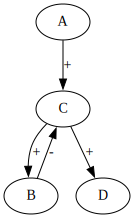

In [37]:
dom = bonesis.InfluenceGraph([
    ("C", "B", {"sign": 1}),
    ("A", "C", {"sign": 1}),
    ("B", "C", {"sign": -1}),
    ("C", "D", {"sign": 1}),
], exact=True, canonic=False) # we disable canonic encoding
dom

This domain encloses all the BNs having exactly (`exact=True`) the specified influence graph, 4 distinct BNs in this case:

In [38]:
dom.canonic = True # we set canonic encoding for enumerating BNs
F = list(bonesis.BoNesis(dom).boolean_networks())
dom.canonic = False
pd.DataFrame(F)

Grounding...done in 0.0s


,A,B,C,D
0,1,C,A|!B,C
1,0,C,A|!B,C
2,0,C,A&!B,C
3,1,C,A&!B,C


Let us explore the attractors of each individual BNs:

In [39]:
for i, f in enumerate(F):
    print(f"Attractors of BN {i}:", list(f.attractors()))

Attractors of BN 0: [{'A': 1, 'B': 1, 'C': 1, 'D': 1}]
Attractors of BN 1: [{'A': 0, 'B': '*', 'C': '*', 'D': '*'}]
Attractors of BN 2: [{'A': 0, 'B': 0, 'C': 0, 'D': 0}]
Attractors of BN 3: [{'A': 1, 'B': '*', 'C': '*', 'D': '*'}]


In this example, we focus on reprogramming the attractors so that the component `D` is fixed to 1.

On the one hand, when reprogramming fixed points only, because one BN already verifies this property, the empty perturbation is a solution:

In [40]:
list(marker_reprogramming_fixpoints(dom, {"D": 1}, 2))

Grounding...done in 0.0s


[{}]

On the other hand, the reprogramming of attractors returns solution that work on every BN:

In [41]:
list(marker_reprogramming(dom, {"D": 1}, 2))

Grounding...done in 0.0s
Grounding...done in 0.0s
Grounding...done in 0.0s


[{'C': 1}, {'D': 1}, {'B': 0, 'A': 1}]

Indeed, fixed `C` to 1, ensures  in each case that `D` is fixed to 1.

The computation of universal solutions for the reprogramming of fixed points can be tackled by following a similar encoding than the reprogramming of attractors, i.e., by identifying perturbations which do not fulfill the property for at least one BN in the domain (the complement results in perturbations working for all the BNs):

In [42]:
def universal_marker_reprogramming_fixpoints(f: BooleanNetwork,
                                             M: dict[str,bool],
                                             k: int):
    bo = bonesis.BoNesis(f)
    coP = bo.Some(max_size=k)
    with bo.mutant(coP):
        x = bo.cfg()
        bo.fixed(x) # x is a fixed point
        x != bo.obs(M) # x does not match with M
    return coP.complementary_assignments()

In [43]:
list(universal_marker_reprogramming_fixpoints(dom, {"D": 1}, 2))

Grounding...done in 0.0s
Grounding...done in 0.0s
Grounding...done in 0.0s


[{'C': 1}, {'A': 1}, {'D': 1}]

Note that in this implementation, we do not ensure the existence of a fixed point after reprogramming.  This is why the perturbation fixing only `A` to 1 is considered as a solution in our example:

In [44]:
for i, f in enumerate(F):
    f["A"] = 1
    print(f"Attractors of BN {i} after fixing A to 1:", list(f.attractors()))

Attractors of BN 0 after fixing A to 1: [{'A': 1, 'B': 1, 'C': 1, 'D': 1}]
Attractors of BN 1 after fixing A to 1: [{'A': 1, 'B': 1, 'C': 1, 'D': 1}]
Attractors of BN 2 after fixing A to 1: [{'A': 1, 'B': '*', 'C': '*', 'D': '*'}]
Attractors of BN 3 after fixing A to 1: [{'A': 1, 'B': '*', 'C': '*', 'D': '*'}]


As BNs 2 and 3 have no fixed point, they fulfill the criteria "all the fixed points match with marker `M`".

## Scalability

In order to evaluate the scalability on realistic BNs, we use the benchmark constituted by <cite data-citet="Moon22"><a href="https://doi.org/10.1016/j.ejor.2021.10.019">Moon et al. (2022a)</a></cite> to evaluate the reprogramming of fixed points (P1). Their benchmark gathers 10 locally-monotone BNs and 1 non-monotone one, that BoNesis cannot address. The dimension of the 10 BNs are respectively 14, 17, 18, 20, 28, 32, 53, 59, 66, and 75. For each of these models, a target marker for reprogramming has been defined from the corresponding published studies. Moreover, a subset of nodes has been declared as uncontrollable to avoid trivial solutions.
We used this benchmark to evaluate the scalability of the P1 and P3 implementation we propose in this paper.

For these 10 models, we applied the P1 and P3 reprogramming for different maximum number of simultaneous perturbations (denoted $k$ in the previous sections), up to $k=6$. In each case, we measured the time for the first solution, for listing up to 100 solutions, and for listing all the solutions, with a timeout of 10 minutes. The experiments have been performed on an Intel(R) Xeon(R) processor at 3.3Ghz with 16BG of RAM.\
In the case of P1, with $k=6$, it took around 1s to get at least one solution for each of the 10 models; up to 100 solutions have been listed in the same timing, except for one model which took 8s. The full listing of solutions of 3 of the larger models have timed out, the rest necessitating between 1 and 18s. With $k=4$, *BoNesis* was able to list all the solutions for all models (up to 5min for one of the larger model).\
In the case of P3, with $k\geq 4$, 3 of the 10 models could not find a single solution in the given time limit; for most of the other models, a first solution was found in around 1s, a couple of models took around 1-2min. The enumeration of the first 100 solutions took a similar time with $k=4$, but timed out with $k=6$ for all but the 4 smallest models. With $k\leq 2$, *BoNesis* has found all the solutions to P3 for all the 10 models in a few seconds maximum.

These experiments testify of the difference of complexity between P1 and P3, and more precisely on the resolution approach taken for P3: the computation of the complementary sets of solutions becomes rapidly intractable for large combinations of perturbation. Indeed, in practice, there are many bad perturbations, thus their enumeration, which is necessary to compute their complement, is an important bottleneck.

Evaluating the scalability of P2 and P4 would require defining initial configurations which are meaningful for the different models, which are not available in the selected benchmark. Nevertheless, because the source constraint does not change the complexity classes, we can conjecture that their scalability should be comparable to P1 and P3 respectively.
Moreover, having benchmarks at larger scale would be insightful, but none of them are available to the best of our knowledge. It should be noted *BoNesis* has been applied to do BN synthesis for models with 1,000 nodes <cite data-citep="bn-synthesis-ICTAI19">(<a href="https://doi.org/10.1109/ICTAI.2019.00014">Chevalier et al., 2019</a>)</cite>, suggesting a potential applicability of *BoNesis* for the reprogramming of large BNs.

As stressed in the introduction, there exists only tools addressing P1 to compare with. The experiments of <cite data-citet="Moon22"><a href="https://doi.org/10.1016/j.ejor.2021.10.019">Moon et al. (2022a)</a></cite> show that their bilevel integer programming-based method systematically outperforms the ASP implementation of pyActoNet <cite data-citep="Biane2018">(<a href="https://doi.org/10.1109/TCBB.2018.2889102">Biane et al., 2018</a>)</cite>. On the same benchmark, *BoNesis* performed either similarly or in shorter time, albeit limited to locally-monotone BNs only.

# Discussion

In this paper, we demonstrated how the *BoNesis* Python library can be employed to fully characterize permanent perturbations which guarantee that all the fixed points or all minimal trap spaces of the perturbed BN have a subset of components fixed to desired values (marker).
We focused on reprogramming for achieving elementary dynamical properties, that are the fixed points or attractors, optionally reachable from a given configuration.
Nevertheless, the snippets shown in this paper can be extended to account for more complex or specific dynamical properties after mutation, e.g., existence of additional trajectories, considering multiple initial configurations.

It should be noted that the candidate combinations of perturbations are computed solely based on the Boolean dynamics, and do not account for experimental feasibility, e.g., in the scope of models of biological systems.
Future work may consider optimization or prioritization of perturbations based on such extra information.
Currently, *BoNesis* enables specifying uncontrollable components which must not be perturbed (`exclude` option for the `Some` object, or `--exclude` for the command line, taking a list of components which should be excluded from the candidate perturbations).

We considered for problems, referred to as P1, P2, P3, P4, where P1-P2 relate to the reprogramming of fixed points, and P3-P4 to the reprogramming of MP attractors (i.e., minimal trap spaces).
The computational complexity of P1-P2 allows an efficient implementation using Answer-Set Programming (ASP), whereas the one of P3-P4 necessitate working around complementary solution to fit into the expressiveness of ASP, limiting their scalability. Future work may explore alternative implementations using different logic frameworks.

The identified perturbations may destroy and create new fixed points and attractors for the BN. This is a significant difference with most of the methods developed in the literature where many focus on the control towards attractors of the unperturbed BNs only. Whereas the problem P1 which has been already addressed with different methods, we are not aware of any other approach tackling P2, P3, and P4.

Besides the four reprogramming problems tackled in this paper, an additional variant would be the marker-reprogramming of fixed points which also ensures the absence of cyclic attractors. Note that its complexity is equivalent to the one of P3/P4, i.e., it can be expressed as a $\exists\forall\exists$-expression. This problem may be relevant for modeling cases where cyclic attractors do not make sense. The programming interface of *BoNesis* do not permit an efficient encoding of this problem at the moment.

This paper focused on permanent perturbations, i.e., enforcing the value of one or several components constantly over time, independently of the state of the system.
*Sequential* reprogramming <cite data-citep="Mandon2017,Pardo2021">(<a href="https://doi.org/10.1007/978-3-319-67471-1_11">Mandon et al., 2017</a>,<a href="https://doi.org/10.1016/j.tcs.2021.03.013">Pardo et al., 2021</a>)</cite> consists in applying sets of perturbations at different time. This can lead to reducing the overall number of component to perturb, by taking advantage of the natural transient dynamics of the system.
Sequential reprogramming brings the BN reprogramming settings closer to classical control theory, as the
control can depend both on time and state of the system.
Having fixed a number of steps, say $m$, the reprogramming problems consists in identifying $m$ sets of perturbations which will be applied in sequence, and their application may be restricted to attractors only
<cite data-citep="Mandon2019">(<a href="https://doi.org/10.1007/978-3-030-31304-3_1">Mandon et al., 2019</a>)</cite>.
Interestingly in that case, having fixed the number of reprogramming steps, the computational complexity remains identical to the  one-step reprogramming with locally-monotone BNs, due to the PTIME complexity of the reachability.
For instance, the 2-steps reprogramming of BNs along fixed points only with the MP update mode can be expressed as the following $\exists\forall$-expression, as P1:

$$\exists P,Q\in\mathbb M^{\leq k}, \forall x,y\in\mathbb B^n,
   f_P(x) = x \Rightarrow
      \operatorname{reach}_Q(x,y) \Rightarrow
      f_Q(y) = y \Rightarrow y\models M$$

"There exist two sets of perturbations $P$ and $Q$, such that for any configuration $x$ and any configuration $y$, if $x$ is a fixed point of under the perturbation $P$, then if $y$ is reachable from $x$ under the perturbation $Q$, then if $y$ is a fixed point under the perturbation $Q$, then it must match with the marker $M$".
The more general 2-steps reprogramming along attractors can be expressed as follows:

$$\exists P,Q\in\mathbb M^{\leq k}, \forall x,y\in\mathbb B^n,
\operatorname{IN-ATTRACTOR}_P(x) \Rightarrow
     \operatorname{reach}_Q(x,y) \Rightarrow
     \operatorname{IN-ATTRACTOR}_Q(y) \Rightarrow y \models M$$
Accounting for $\operatorname{IN-ATTRACTOR}$, this leads to an $\exists\forall\exists$-expression, as for the single-step reprogramming.
Future work may then investigate the encoding of sequential reprogramming with *BoNesis*.

Finally, we demonstrated how *BoNesis* can be employed to reason on the reprogramming of BNs, leading to either solutions that work for at least one BN of the ensemble, or working on each of them (universal reprogramming). We believe that reasoning on ensemble of models is a promising direction to address the robustness of predictions in the scope of applications in systems biology.

### Acknowledgements

The author would like to thank Kyungduk Moon and Kangbok Lee for stimulating discussions and for providing the model and configuration files for the benchmarks of <cite data-citet="Moon22"><a href="https://doi.org/10.1016/j.ejor.2021.10.019">Moon et al. (2022a)</a></cite>.

### Software and data availability

The software *BoNesis* is available at [github.com/bnediction/bonesis](https://github.com/bnediction/bonesis). The code of this paper uses version 0.4.92.
The notebook, models, and instructions for reproducing the results are available at [github.com/bnediction/reprogramming-with-bonesis](https://github.com/bnediction/reprogramming-with-bonesis).

### Funding

This work has been supported by the French Agence Nationale pour la Recherche (ANR) in the scope of the
project [BNeDiction](https://bnediction.github.io) (grant number ANR-20-CE45-0001).

<!-- vi:spell spelllang=en_us
-->